In [72]:

import torch
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sampler import InfiniteSamplerWrapper

import model

In [73]:
def load_dataset(min_max_scalar, parameters=['Open', 'High', 'Low', 'Close'], target_index=3, img_size=8, predLen=1, train_ratio=0.9):
    apple = yf.Ticker("AAPL")
    df = apple.history(start='2001-01-19', end='2022-05-13', actions=False)
    df = df[parameters]
    data_values = df.values

    scaled_data = min_max_scalar.fit_transform(data_values)

    X, Y = [], []
    for i in range(len(scaled_data)-img_size**2-predLen):
        a = np.array(scaled_data[i:(i+img_size**2), :])
        X.append(a.T.reshape(-1, img_size, img_size))
        b = np.array(scaled_data[(i+img_size**2):(i+img_size**2+predLen), target_index])
        Y.append(b.reshape(-1))
    
    X = np.array(X)
    Y = np.array(Y)

    tensor_x = torch.Tensor(X) # transform to torch tensor
    tensor_y = torch.Tensor(Y)

    dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y)

    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    return train_dataset, test_dataset

In [74]:
model_path = 'experiments/mixerModel_21000.pth'

In [75]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

min_max_scalar = MinMaxScaler(feature_range=(0, 1))
_, test_set = load_dataset(min_max_scalar, ['Close'], target_index=0, img_size=8, predLen=1, train_ratio=0.9)

test_iter = iter(torch.utils.data.DataLoader(
    test_set, batch_size=4,
    sampler=InfiniteSamplerWrapper(test_set),
    num_workers=4))

mixerModel = model.MLPMixer(in_channels=1, dim=512, num_classes=1, patch_size=4, image_size=(8, 8), depth=16, token_dim=256, channel_dim=2048)

mixerModel.eval()

# mixerModel.load_state_dict(torch.load(model_path))

mixerModel.to(device)

cuda


MLPMixer(
  (to_patch_embedding): Sequential(
    (0): Conv2d(1, 512, kernel_size=(4, 4), stride=(4, 4))
    (1): Rearrange('b c h w -> b (h w) c')
  )
  (mixer_blocks): ModuleList(
    (0-15): 16 x MixerBlock(
      (token_mix): Sequential(
        (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (1): Rearrange('b n d -> b d n')
        (2): FeedForward(
          (net): Sequential(
            (0): Linear(in_features=4, out_features=256, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=256, out_features=4, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (3): Rearrange('b d n -> b n d')
      )
      (channel_mix): Sequential(
        (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (1): FeedForward(
          (net): Sequential(
            (0): Linear(in_features=512, out_features=2048, bias=True)
            (1): GELU(appr

In [76]:
from tqdm import tqdm
predictions = []
groundTruths = []
tqdm_iters = tqdm(range(int(len(test_set)/4)))
for i in tqdm_iters:

    batch, out = next(test_iter)

    pred = mixerModel(batch.to(device))

    predictions += pred.cpu().tolist()
    groundTruths += out.cpu().tolist()


100%|██████████| 132/132 [00:01<00:00, 102.79it/s]


In [77]:
predictions = min_max_scalar.inverse_transform(np.array(predictions)).flatten()
groundTruths = min_max_scalar.inverse_transform(np.array(groundTruths)).flatten()

# predictions = np.array(predictions).flatten()
# groundTruths = np.array(groundTruths).flatten()

In [78]:
print(predictions.shape)
print(groundTruths.shape)

(528,)
(528,)


In [79]:
predictions

array([36.05589109, 38.39278694, 17.96559903,  2.47299468, 10.44174821,
       12.96578031, 37.92266989,  6.24625797, 12.2280428 , 19.26427593,
        8.09621066, 17.07376462, 18.85601864, 56.82647123, 56.60353039,
        2.0923549 , 21.1492621 , 27.29095995, 22.37192181,  2.81809675,
       23.6047225 , 40.63357539, 19.62020694, 26.99485166, 16.95314425,
       37.37500284, 23.07387485, 27.1294873 ,  2.27601918,  6.95679772,
        3.90602023, 35.01644642, 56.91979193, 22.2289395 , 19.38662491,
       26.93103933,  2.36265745,  2.39562304, 25.01715227, 21.43184193,
       19.50074255,  2.09144835, 27.92408381,  2.08591519,  2.54605218,
       36.19872321, 26.6326888 , 53.7270996 , 20.01052908, 22.34642048,
        2.23571941, 19.8204318 ,  2.38618342, 47.39419811, 16.97307085,
       34.1949217 , 40.66695402,  9.19714363,  2.0668938 , 18.26462545,
       56.98816918,  4.86354712, 14.91936232, 24.02109043, 21.19436684,
        2.50324063, 54.98834253, 27.13554615, 37.56771113, 19.63

In [80]:
groundTruths

array([ 40.98483554,  45.73897734,  12.53308246,   0.37741151,
         4.60017442,   5.97128321,  37.55401905,   2.18807624,
         5.09823652,  13.01831444,   2.85710995,  10.18979921,
        13.6909616 , 156.58058315, 173.17184204,   0.21523023,
        17.34455263,  27.72093682,  18.56615962,   0.5227679 ,
        22.63032124,  49.51393571,  13.17919569,  24.61982719,
         9.55865876,  41.71285717,  21.86058369,  26.98242016,
         0.33451664,   1.88948147,   1.04962776,  36.12069311,
       155.43070603,  19.86766075,  14.8601471 ,  28.89894372,
         0.39302347,   0.36680144,  26.64985151,  20.54381877,
        15.20300828,   0.2241731 ,  28.64923024,   0.23144892,
         0.41985124,  40.11846089,  25.99445824, 116.13445658,
        16.322618  ,  19.62470883,   0.34164065,  16.39400321,
         0.23690504,  67.49477562,  10.07763749,  35.37324509,
        49.70771148,   3.71105965,   0.215534  ,  14.95761164,
       173.53123161,   1.08979452,   7.53246246,  22.53

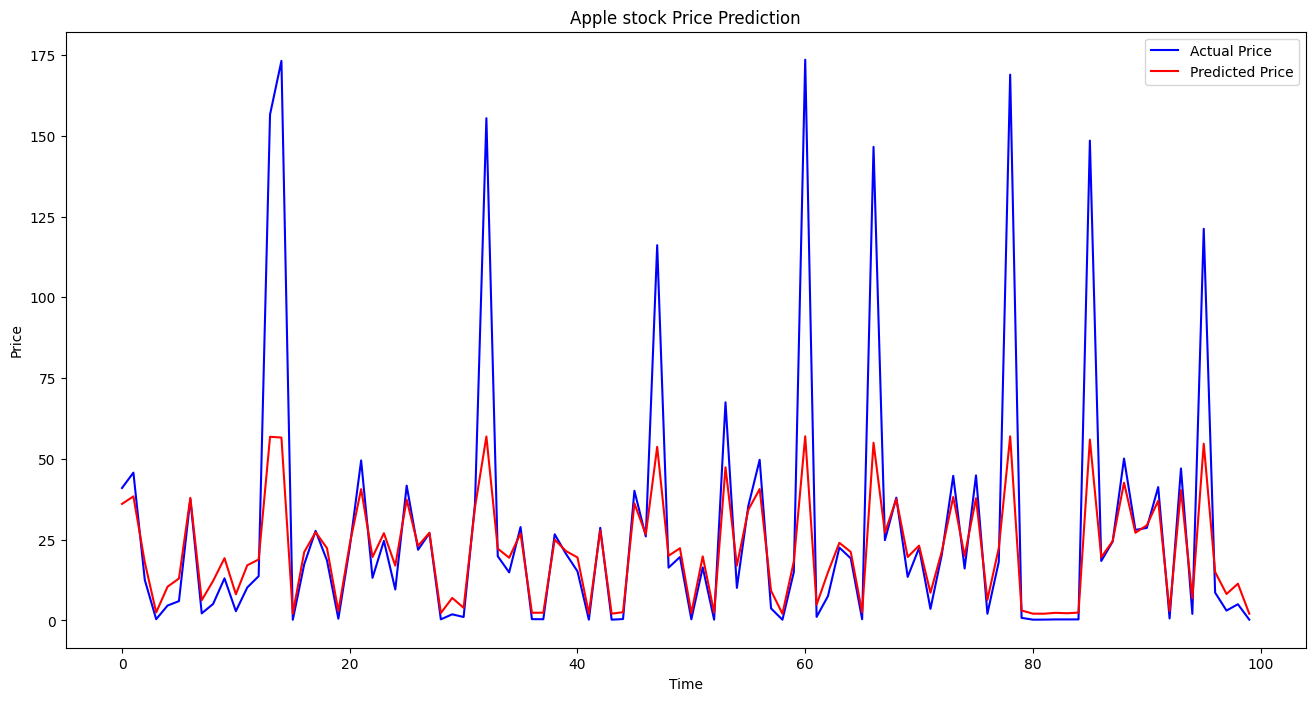

In [81]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(groundTruths[:100], color='blue', label='Actual Price')
plt.plot(predictions[:100] , color='red', label='Predicted Price')
plt.title('Apple stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()